# Barcelona's neighborhoods

### *Analyzing Barcelona's barrios' character by using Foursquare venues data* 
<br><br>

Before we get the data and start exploring it, let's download all the dependencies that we will need. <br>
(Uncomment to install BeautifulSoup if needed)

In [1]:
import pandas as pd # library for data analsysis
import urllib.request # import the library we use to open URLs

# import the BeautifulSoup library so we can parse HTML and XML documents
!conda install -c anaconda beautifulsoup4 bs4 --yes
print("BeautifulSoup instalation complete")

from bs4 import BeautifulSoup

!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder
print('Geocoder installation complete!')

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Folium installation complete!')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import numpy as np # library for vectorized computation

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import requests # library to handle requests
print('Geopy installation complete!')

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4
    - bs4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.1       |           py36_0         168 KB  anaconda
    bs4-4.9.1                  |                0           4 KB  anaconda
    ca-certificates-2020.6.24  |                0         133 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    soupsieve-2.0.1            |             py_0          33 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following NEW packages will be INSTALLED:

  beautifulsoup4     anaconda/linux-64::beautifulsoup4-4.9.1-py

Obtain the list with Barcelona's districts (barrios) from Wikipedia page: <br> 
https://en.wikipedia.org/wiki/Districts_of_Barcelona

First we need to specify which URL/web page we are going to be scraping and open it using urllib.request. <br>
Then we parse the HTML from the URL into a BeautifulSoup object and extract the postal codes table into pc_table.


In [2]:
# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/Districts_of_Barcelona"

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "html.parser")
# extract the postal codes table
pc_table=soup.find_all(class_ ='wikitable')[0]
#pc_table

Let's get from pc_table the data we want to include to the dataframe:

In [3]:
District=[]
Neighborhood=[]

for row in pc_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==8:
        District.append(cells[1].find(text=True).replace('\n', ''))
        list = cells[5].find_all(text=True)
        nei = ''
        for s in list:
            nei += s.replace('\n', '')
        Neighborhood.append(nei) 

Now let's produce the dataframe:

In [4]:
df=pd.DataFrame(District,columns=['District'])
df['Neighborhood']=Neighborhood
df

,District,Neighborhood
0,Ciutat Vella,"La Barceloneta, El Gòtic, El Raval, Sant Pere,..."
1,Eixample,"L'Antiga Esquerra de l'Eixample, La Nova Esque..."
2,Sants-Montjuïc,"La Bordeta, la Font de la Guatlla, Hostafrancs..."
3,Les Corts,"les Corts, la Maternitat i Sant Ramon, Pedralbes"
4,Sarrià-Sant Gervasi,"El Putget i Farró, Sarrià, Sant Gervasi - la B..."
5,Gràcia,"Vila de Gràcia, el Camp d'en Grassot i Gràcia ..."
6,Horta-Guinardó,"El Baix Guinardó, El Guinardó, Can Baró, El Ca..."
7,Nou Barris,"Can Peguera, Canyelles, Ciutat Meridiana, La G..."
8,Sant Andreu,"Baró de Viver, Bon Pastor, El Congrés i els In..."
9,Sant Martí,"El Besòs i el Maresme, el Clot, El Camp de l'A..."


Let's find the coordinates for every district:

In [41]:
def get_coords(place):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        #print('get_coords for ',place)
        g = geocoder.arcgis(place)
        lat_lng_coords = g.latlng
        
    return lat_lng_coords[0], lat_lng_coords[1]

Latitude = []
Longitude = []

for pc in df['District']:
    lat, long = get_coords('Distrito ' + pc + ', Província de Barcelona, Catalonia, ESP')
    Latitude.append(lat)
    Longitude.append(long)
    
df["Latitude"] = Latitude
df["Longitude"] = Longitude

df

,District,Neighborhood,Latitude,Longitude
0,Ciutat Vella,"La Barceloneta, El Gòtic, El Raval, Sant Pere,...",41.38022,2.17319
1,Eixample,"L'Antiga Esquerra de l'Eixample, La Nova Esque...",41.38896,2.16179
2,Sants-Montjuïc,"La Bordeta, la Font de la Guatlla, Hostafrancs...",41.37263,2.15460
3,Les Corts,"les Corts, la Maternitat i Sant Ramon, Pedralbes",41.38712,2.13007
4,Sarrià-Sant Gervasi,"El Putget i Farró, Sarrià, Sant Gervasi - la B...",41.40104,2.13940
5,Gràcia,"Vila de Gràcia, el Camp d'en Grassot i Gràcia ...",41.40237,2.15641
6,Horta-Guinardó,"El Baix Guinardó, El Guinardó, Can Baró, El Ca...",41.41849,2.16770
7,Nou Barris,"Can Peguera, Canyelles, Ciutat Meridiana, La G...",41.44163,2.17727
8,Sant Andreu,"Baró de Viver, Bon Pastor, El Congrés i els In...",41.43541,2.18982
9,Sant Martí,"El Besòs i el Maresme, el Clot, El Camp de l'A...",41.41814,2.19933


Let's visualize the data of the Dataframe we have created so far:

In [42]:
# Get the Barcelona's coordinates
address = 'Barcelona Spain'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinates of Barcelona are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district, neighborhood in zip(df['Latitude'], df['Longitude'], df['District'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  
    
map_bcn

The geograpical coordinates of Barcelona are 41.3828939, 2.1774322.


Let's import Foursquare credentials:

In [6]:
import foursquare_credentials as cred

CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN = cred.foursquare_credentials()

radius = 500
LIMIT = 100
VERSION = '20180605' # Foursquare API version

Now, let's define a function to get the top 100 nearby venues for a given neighborhood:

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
bcn_venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
bcn_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ciutat Vella,41.38088,2.17223,Liceu Opera Barcelona (Gran Teatro del Liceo),41.380713,2.173606,Opera House
1,Ciutat Vella,41.38088,2.17223,Cañete,41.379154,2.173092,Tapas Restaurant
2,Ciutat Vella,41.38088,2.17223,Mercat de Sant Josep - La Boqueria,41.381959,2.172011,Market
3,Ciutat Vella,41.38088,2.17223,Kӕlderkold,41.381723,2.173348,Beer Bar
4,Ciutat Vella,41.38088,2.17223,La Robadora,41.379500,2.170463,Gastropub


We get all the unique venue categories and create a dictionary with new categorization:

In [13]:
bcn_venues['Venue Category'].unique()

array(['Opera House', 'Market', 'Tapas Restaurant', 'Beer Bar',
       'Gastropub', 'Mediterranean Restaurant', 'Spanish Restaurant',
       'Asian Restaurant', 'Garden', 'Jazz Club', 'Falafel Restaurant',
       'Donut Shop', 'Seafood Restaurant', 'Café', 'Italian Restaurant',
       'Ice Cream Shop', 'Monument / Landmark', 'Burger Joint', 'Bar',
       'Hostel', 'Plaza', 'Theater', 'Pharmacy', 'Movie Theater',
       'Pizza Place', 'Dessert Shop', 'Sandwich Place', 'Snack Place',
       'Coffee Shop', 'Hotel', 'Speakeasy', 'Restaurant',
       'Furniture / Home Store', 'Gift Shop', 'Fabric Shop',
       'Pedestrian Plaza', 'Indie Theater', 'Roof Deck', 'Baby Store',
       'Japanese Restaurant', 'Indian Restaurant', 'Hotel Pool',
       'Pie Shop', 'Sporting Goods Shop', 'Boarding House', 'Candy Store',
       'Hotel Bar', 'Ramen Restaurant', 'Gourmet Shop', 'Sports Bar',
       'Arts & Crafts Store', 'Bookstore', 'Noodle House',
       'Fast Food Restaurant', 'Tea Room', 'Art Galler

In [20]:
bcn_venue_cat_dict = {'Opera House':'Culture', 'Market':'Groceries', 'Tapas Restaurant':'Restaurant', 'Beer Bar':'Nightlife',
       'Gastropub':'Restaurant', 'Mediterranean Restaurant':'Restaurant', 'Spanish Restaurant':'Restaurant',
       'Asian Restaurant':'Restaurant', 'Garden':'Park', 'Jazz Club':'Nightlife', 'Falafel Restaurant':'Restaurant',
       'Donut Shop':'Dessert', 'Seafood Restaurant':'Restaurant', 'Café':'Coffee', 'Italian Restaurant':'Restaurant',
       'Ice Cream Shop':'Dessert', 'Monument / Landmark':'Sight-seeing', 'Burger Joint':'Restaurant', 'Bar':'Nightlife',
       'Hostel':'Hotel', 'Plaza':'Sight-seeing', 'Theater':'Culture', 'Pharmacy':'Misc', 'Movie Theater':'Culture',
       'Historic Site':'Sight-seeing', 'Pizza Place':'Restaurant', 'Dessert Shop':'Dessert', 'Sandwich Place':'Restaurant',
       'Snack Place':'Restaurant', 'Coffee Shop':'Coffee', 'Hotel': 'Hotel', 'Speakeasy':'Nightlife', 'Restaurant':'Restaurant',
       'Furniture / Home Store':'Shop', 'Gift Shop':'Shop', 'Fabric Shop':'Shop',
       'Pedestrian Plaza':'Sight-seeing', 'Indie Theater':'Culture', 'Roof Deck':'Nightlife', 'Baby Store':'Misc',
       'Japanese Restaurant':'Restaurant', 'Indian Restaurant':'Restaurant', 'Hotel Pool':'Pool',
       'Pie Shop':'Restaurant', 'Sporting Goods Shop':'Shop', 'Boarding House':'Misc', 'Candy Store':'Dessert',
       'Hotel Bar':'Nightlife', 'Ramen Restaurant':'Restaurant', 'Gourmet Shop':'Shop', 'Sports Bar':'Nightlife',
       'Arts & Crafts Store':'Shop', 'Bookstore':'Shop', 'Noodle House':'Restaurant',
       'Fast Food Restaurant':'Restaurant', 'Tea Room':'Coffee', 'Art Gallery':'Culture',
       'Cultural Center':'Culture', 'Wine Bar':'Nightlife', 'Supermarket':'Groceries', 'Locksmith':'Misc',
       'Construction & Landscaping':'Misc', 'Fountain':'Sight-seeing', 'Art Museum':'Culture',
       'Scenic Lookout':'Sight-seeing', 'Palace':'Sight-seeing', 'Track':'Misc', 'Peruvian Restaurant': 'Restaurant',
       'Taco Place':'Restaurant', 'Cocktail Bar':'Nightlife', 'Liquor Store':'Shop', 'Clothing Store':'Shop',
       'Nightclub':'Nightlife', 'Performing Arts Venue':'Culture', 'Indie Movie Theater':'Culture',
       'Deli / Bodega':'Shop', 'Mexican Restaurant': 'Restaurant', 'Bakery':'Dessert', 'Breakfast Spot':'Coffee',
       'Paella Restaurant':'Restaurant', 'Gay Bar':'Nightlife', 'Sushi Restaurant':'Restaurant', 'Brewery':'Misc',
       'Turkish Restaurant':'Restaurant', 'Museum':'Culture', 'Grocery Store':'Groceries',
       'Vegetarian / Vegan Restaurant':'Restaurant', 'Middle Eastern Restaurant':'Restaurant',
       'Fried Chicken Joint':'Restaurant', 'Park':'Sight-seeing', 'Cosmetics Shop':'Shop', 'Shopping Mall':'Shop',
       'Thai Restaurant':'Restaurant', 'Gym':'Sports', 'Chinese Restaurant':'Restaurant',
       'Polish Restaurant':'Restaurant', 'Pub':'Nightlife', 'Toy / Game Store':'Shop',
       'Electronics Store':'Shop', 'Empanada Restaurant':'Restaurant', 'Hawaiian Restaurant':'Restaurant',
       'Health & Beauty Service':'Misc', 'Accessories Store':'Shop',
       'South Indian Restaurant':'Restaurant', 'Massage Studio':'Misc', 'Salad Place':'Restaurant',
       'Gym / Fitness Center':'Sports', 'Pool':'Pool', 'Building':'Sight-seeing', 'Multiplex':'Culture',
       'Theme Park':'Culture', 'Optical Shop':'Shop', 'Diner':'Restaurant', 'American Restaurant':'Restaurant',
       'Sports Club':'Sports', 'Playground':'Sports', 'Farmers Market':'Groceries',
       'Athletics & Sports':'Sports', 'Food':'Restaurant', 'Bed & Breakfast':'Hotel', 'Coworking Space':'Misc',
       'Organic Grocery':'Groceries', 'Gym Pool':'Pool', 'Paper / Office Supplies Store':'Shop',
       'Soccer Field':'Sports', 'Hardware Store':'Shop', 'Pet Store':'Shop', 'Hot Dog Joint':'Restaurant',
       'Shipping Store':'Shop', 'Skating Rink':'Sports', 'Arts & Entertainment':'Culture',
       'Cafeteria':'Coffee', 'Argentinian Restaurant':'Restaurant', 'Gluten-free Restaurant':'Restaurant',
       'Record Shop':'Shop', 'Sauna / Steam Room':'Sports', 'Public Art':'Culture', 'Dance Studio':'Sports',
       'Antique Shop':'Shop', 'Bistro':'Restaurant', 'Beer Garden':'Nightlife', 'Food Court':'Restaurant', 'Rock Club':'Nightlife',
       'Auto Garage':'Misc', 'Salon / Barbershop':'Misc', 'Department Store':'Shop',
       'Lebanese Restaurant':'Restaurant', 'Kebab Restaurant':'Restaurant', 'Music Venue':'Nightlife',
       'Mobile Phone Shop':'Shop','Perfume Shop':'Shop','BBQ Joint':'Restaurant','Yoga Studio':'Sports','Rental Car Location':'Transportation',
        'Video Game Store':'Shop','Dog Run':'Misc','Train Station':'Transportation', 'Food & Drink Shop':'Shop','Flea Market':'Market',
        'Metro Station':'Transportation'}


Let's use the dictionary to re-categorize the venues:

In [23]:
for key in bcn_venues['Venue Category']:
    if key not in bcn_venue_cat_dict.keys(): 
      print("Missing key: ", key) 

for item in bcn_venue_cat_dict:
    bcn_venues.replace(to_replace =item, value =bcn_venue_cat_dict[item],inplace = True)
        
bcn_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ciutat Vella,41.38088,2.17223,Liceu Opera Barcelona (Gran Teatro del Liceo),41.380713,2.173606,Culture
1,Ciutat Vella,41.38088,2.17223,Cañete,41.379154,2.173092,Restaurant
2,Ciutat Vella,41.38088,2.17223,Mercat de Sant Josep - La Boqueria,41.381959,2.172011,Groceries
3,Ciutat Vella,41.38088,2.17223,Kӕlderkold,41.381723,2.173348,Nightlife
4,Ciutat Vella,41.38088,2.17223,La Robadora,41.379500,2.170463,Restaurant


array(['Culture', 'Groceries', 'Restaurant', 'Nightlife', 'Sight-seeing',
       'Dessert', 'Coffee', 'Hotel', 'Misc', 'Shop', 'Pool', 'Sports'],
      dtype=object)

In [24]:
bcn_test = bcn_venues.groupby(['District','District Latitude','District Longitude','Venue Category']).count().reset_index()
bcn_test = bcn_test[['District','District Latitude','District Longitude','Venue Category','Venue']]
bcn_test.columns = ['District','District Latitude','District Longitude','Venue Category','Count']
bcn_test.head()

,District,District Latitude,District Longitude,Venue Category,Count
0,Ciutat Vella,41.38088,2.17223,Coffee,6
1,Ciutat Vella,41.38088,2.17223,Culture,8
2,Ciutat Vella,41.38088,2.17223,Dessert,8
3,Ciutat Vella,41.38088,2.17223,Groceries,1
4,Ciutat Vella,41.38088,2.17223,Hotel,6


Let's create a dataframe with one row per district and a column per venue category. For each district we have the count per venue category:

In [25]:
new_df = bcn_test[['District','District Latitude','District Longitude']].drop_duplicates(ignore_index = True)
col_array = bcn_venues['Venue Category'].unique()
for col in col_array:
    new_df[col] = 0
new_df.set_index("District",drop=True,inplace=True)

for i in range(0,bcn_test.shape[0]):
    dist = bcn_test['District'].loc[i]
    cat = bcn_test['Venue Category'].loc[i]
    new_df.loc[dist,cat] = bcn_test['Count'].loc[i]
new_df['Total'] = new_df.drop(columns =['District Latitude', 'District Longitude']).sum(axis=1) 
#new_df.append(new_df.agg(['sum']))
new_df.reset_index(inplace=True)
new_df

,District,District Latitude,District Longitude,Culture,Restaurant,Groceries,Nightlife,Sight-seeing,Dessert,Coffee,Hotel,Misc,Shop,Pool,Sports,Transportation,Market,Total
0,Ciutat Vella,41.380880,2.172230,8,40,1,11,8,8,6,6,3,7,1,1,0,0,100
1,Eixample,41.595120,1.918080,0,1,1,0,0,0,0,0,3,0,0,0,0,0,5
2,Gràcia,41.430090,2.181500,1,24,4,3,3,5,0,0,1,8,1,0,1,1,52
3,Horta-Guinardó,41.421260,2.173890,0,14,4,2,4,0,2,0,1,2,0,3,0,0,32
4,Les Corts,41.386950,2.136310,0,45,4,7,2,7,6,2,1,15,0,1,0,0,90
5,Nou Barris,41.416547,1.683020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
6,Sant Andreu,41.431390,2.189310,3,20,6,6,3,1,7,0,2,6,1,4,1,0,60
7,Sant Martí,41.401460,2.194160,4,51,1,9,0,3,10,7,2,9,0,4,0,0,100
8,Sants-Montjuïc,41.371720,2.151570,9,36,1,10,14,4,6,4,4,4,0,0,0,0,92
9,Sarrià-Sant Gervasi,41.392246,2.132272,4,47,3,3,2,1,7,2,0,22,1,2,1,0,95


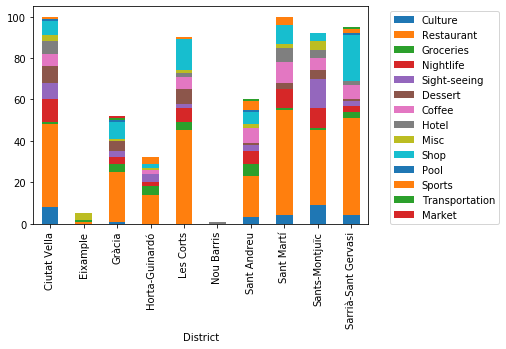

In [26]:
import matplotlib.pyplot as plt
new_df.drop(columns =['District Latitude', 'District Longitude','Total']).plot(x ='District', kind = 'bar', stacked=True).legend(
    loc='right')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Let's inspect the Coffee, Restaurant and Nightlife options for each district:

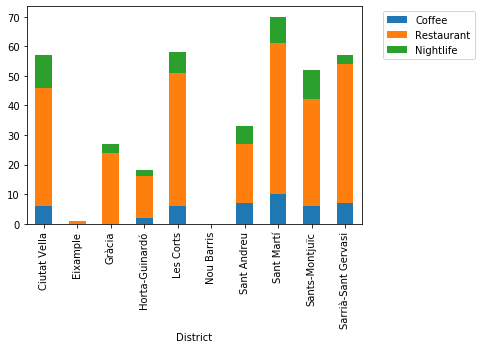

In [33]:
new_df[['District','Coffee','Restaurant','Nightlife']].plot(x ='District', kind = 'bar', stacked=True).legend(
    loc='right')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Ciutat Vella, Sant Marti and Sants-Montjuic offer more nightlife options. <br>
Sant Marti offers the most restaurant and coffee options but Ciutat Vella offers more nightlife options.

Let's inspect the Culture and Sight-seeing options for each district:

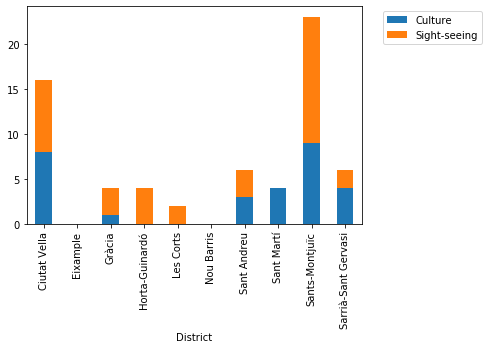

In [31]:
new_df[['District','Culture','Sight-seeing']].plot(x ='District', kind = 'bar', stacked=True).legend(
    loc='right')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Sants-Montjuic and Ciutat Vella offers the most options for culture and sight-seeing.

Because Ciutat Vella offers many options both for culture and fun it should be more suitable for the average tourist.

## The end!